# <center> Evaluate some examples on the trained model </center>

### Push the model to the HF Hub

In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

model_path = "trocr-base-steel"
processor = TrOCRProcessor.from_pretrained(model_path)
# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")
model = VisionEncoderDecoderModel.from_pretrained(model_path)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

In [ ]:
# processor.save_pretrained(model_path)

In [2]:
# Push the model and processor to the hub
model.push_to_hub(model_path)
processor.push_to_hub(model_path)

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/cayjobla/trocr-base-steel/commit/25252446f708739b97b8557bfffaa978cfb3cad5', commit_message='Upload processor', commit_description='', oid='25252446f708739b97b8557bfffaa978cfb3cad5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/cayjobla/trocr-base-steel', endpoint='https://huggingface.co', repo_type='model', repo_id='cayjobla/trocr-base-steel'), pr_revision=None, pr_num=None)

## Manual Evaluation

In [2]:
def pipeline(image):
    pixel_values = processor(image, return_tensors="pt").pixel_values
    outputs = model.generate(pixel_values)
    translated_english = processor.decode(outputs[0], skip_special_tokens=True)
    return translated_english

### Examples in training data

In [3]:
from datasets import load_dataset

dataset = load_dataset("cayjobla/iam-steel", split="train")
dataset

Dataset({
    features: ['image', 'label', 'english', 'steel'],
    num_rows: 11344
})

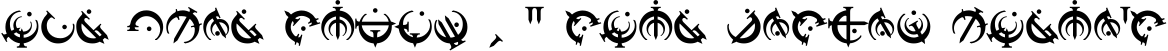

English: and proud sight , " said moscow radio's
Deseret: and prod sight , " said moskow radio's


In [4]:
example_idx = 3247
example = dataset[example_idx]
display(example["image"])
print("English:", example["english"])
print("Deseret:", example["steel"])

In [5]:
output_text = pipeline(example["image"])
print("Translated English:", output_text)

Translated English: and proud sight , " said moscow radio's


### Hand-generated examples

In [6]:
# Pick a text excerpt to translate to Deseret and render
text = "The dog decided to run around and eat his toys."

In [7]:
from translate import english_to_steel_phonetics
from render_text import text_to_image
from PIL import ImageFont

def translate_and_render(text, fontsize=50):
    font = ImageFont.truetype("AlloyofLaw/AlloyofLawExpanded.ttf", size=fontsize)
    steel_text = english_to_steel_phonetics(text)
    return text_to_image(steel_text, font=font)

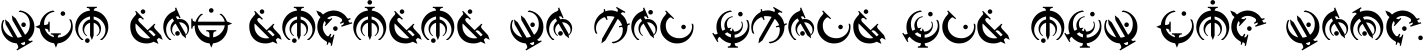

In [8]:
image = translate_and_render(text)
display(image)

In [9]:
output_text = pipeline(image)
print("Translated English:", output_text)

Translated English: the dog decided to run around and eat his toys.


### Screenshots from actual use cases

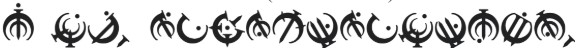

In [10]:
from PIL import Image

screenshot = "i_am_unfortunately.jpg"
image = Image.open(screenshot).convert("RGB")
display(image)

In [11]:
output_text = pipeline(image)
print("Translated English:", output_text)

Translated English: i am, unfortunately ,


### Out of domain examples

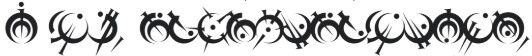

In [12]:
# Example with a different font
screenshot = "i_am_unfortunately_fe.jpg"
image = Image.open(screenshot).convert("RGB")
display(image)

In [13]:
output_text = pipeline(image)
print("Translated English:", output_text)

Translated English: i 20,000. unhushly.


As expected, the model clearly does not perform as well on out-of-domain examples. Note that the font used in this example is fairly similar, but the thinner, spikier characters may cause trouble for the model.

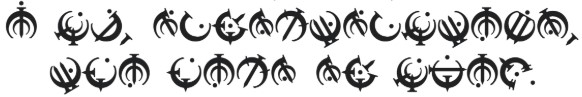

In [14]:
# Example with stacked lines of text (probably won't do well)
screenshot = "i_am_unfortunately_stacked.jpg"
image = Image.open(screenshot).convert("RGB")
display(image)

In [15]:
output_text = pipeline(image)
print("Translated English:", output_text)

Translated English: e amo hajorusa areas.


Again as expected, the model does not perform well on this example. The model was not trained only on single-line text, so it is not suprising that it cannot handle this example.

It may be beneficial to augment the training data with examples in the other font so that it can detect both. Im not sure whether the TrOCR model can be trained for multi-line text, but I can consider adding text line detection as a first step in the pipeline.

## Actual Evaluation metrics

According to the wandb logging of the CER (character error rate) on the validation set, the model has a final CER of around 0.023, which is actually pretty good. That said, the evaluation curve has not bottomed out, so it is possible that the model could be further improved with more training. Since I am already training the model on 10 epochs of my existing data, I think I should look into augmenting with other data instead of just running more epochs. 

# With Line Segmentation

In [10]:
from PIL import Image
from line_segmentation import LineSegmenter

def new_pipeline(filename):
    # Load image
    image = Image.open(filename).convert("RGB")
    print("Original image:")
    display(image)

    # Line segmentation
    segmenter = LineSegmenter()
    lines = segmenter.segment(image)
    text = ""
    for i, line in enumerate(lines):
        print(f"Line {i+1}:")
        display(line)
        output_text = pipeline(line)
        print("Translated English:", output_text)
        text += output_text + "\n"
    return text

Original image:


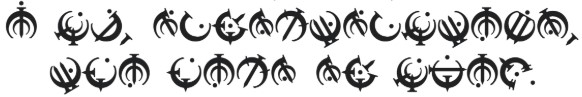

Line 1:


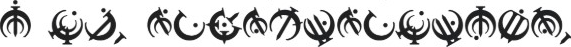

Translated English: i am, unfortunately,
Line 2:


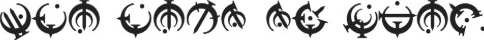

Translated English: the hero of ages.
i am, unfortunately,
the hero of ages.



In [14]:
# Example with stacked lines of text
screenshot = "examples/steel/i_am_unfortunately_stacked.jpg"
translation = new_pipeline(screenshot)
print(translation)

Original image:


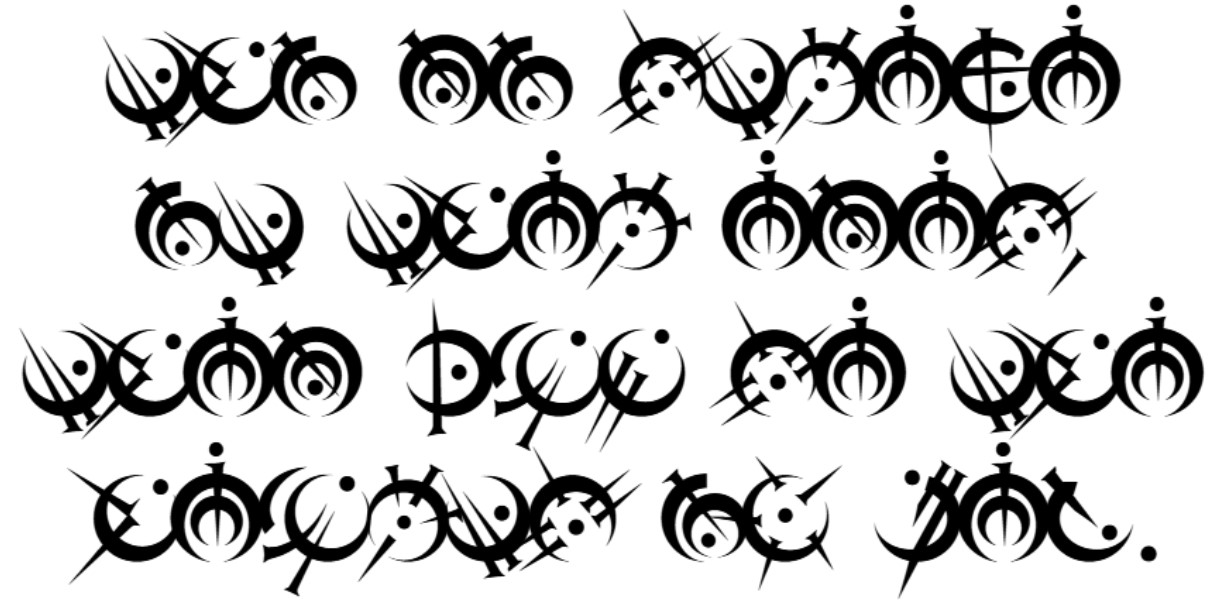

Line 1:


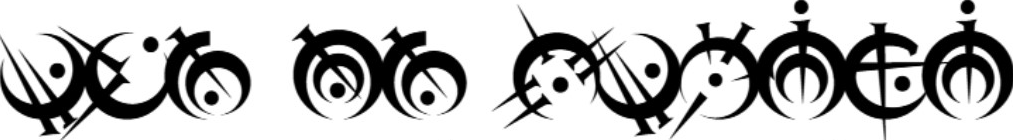

Translated English: the you studied
Line 2:


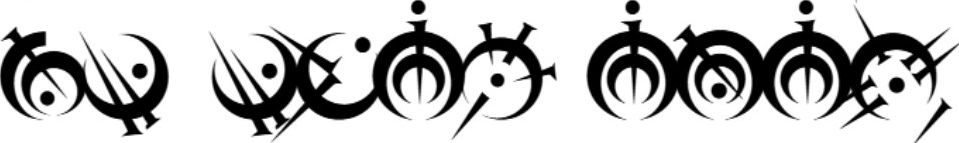

Translated English: at their gives
Line 3:


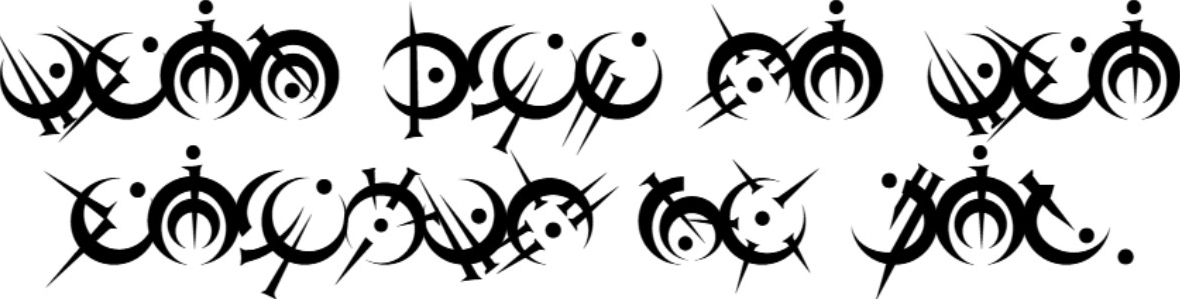

Translated English: was shuausau was
the you studied
at their gives
was shuausau was



In [15]:
# Larger Example
screenshot = "examples/steel/steel_example.jpg"
translation = new_pipeline(screenshot)
print(translation)

Original image:


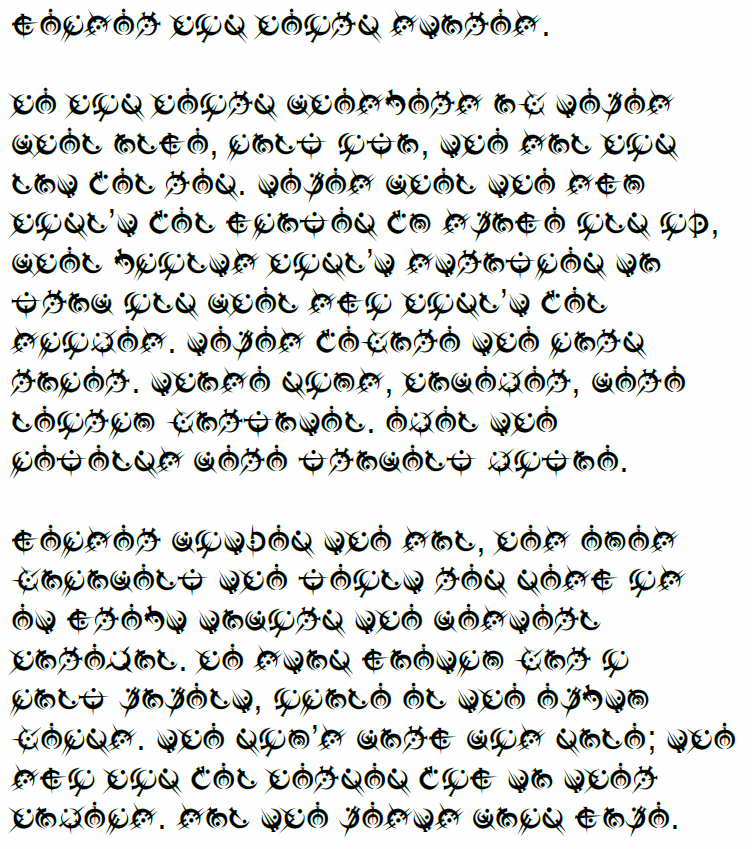

Line 1:


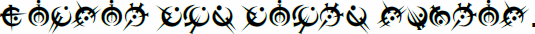

Translated English: cimpiene 15th, hifrw spoting .
Line 2:


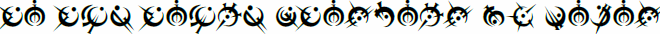

Translated English: his h/m. hifren whisphips of tidizing
Line 3:


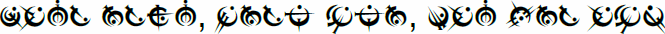

Translated English: which enk i , being 1/ge , this gun when
Line 4:


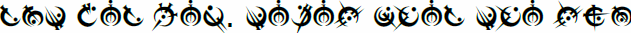

Translated English: not b in p.m. tillis which this spy
Line 5:


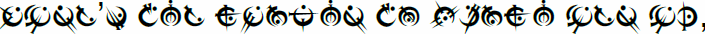

Translated English: hahn't him gllegily by pluc i 1um.s.
Line 6:


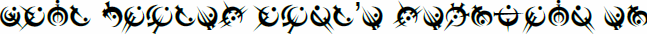

Translated English: which slightly within't v streing himu we
Line 7:


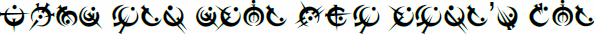

Translated English: gnew lynw which sexh. huhun't him
Line 8:


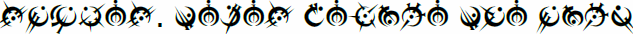

Translated English: shphmis . vixis bit hi this jury
Line 9:


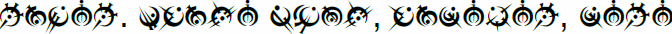

Translated English: sunish . thoyie whys , kwizir , wicki
Line 10:


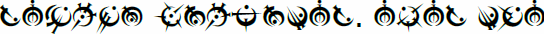

Translated English: nighty hurgy outin. 3.in this
Line 11:


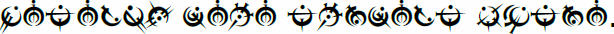

Translated English: highings wiri growing 15/g.i.
Line 12:


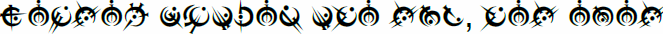

Translated English: silynish whichthith this gun , his lying
Line 13:


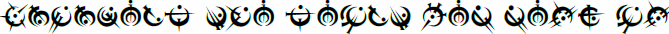

Translated English: hulowing this gibant phil nigps by
Line 14:


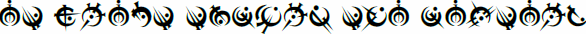

Translated English: it knightiveighrwrwrwl this wipview
Line 15:


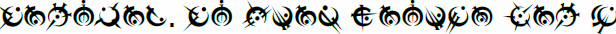

Translated English: hurican . di sten quietly her west
Line 16:


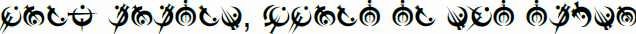

Translated English: lung bullet , phuanie in this ivory
Line 17:


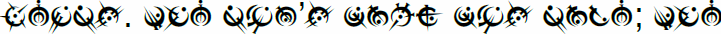

Translated English: phils . this . this why's work why lynie. who
Line 18:


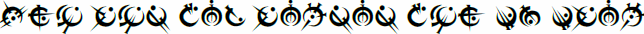

Translated English: each 5/000 him him himful 1/416 to this
Line 19:


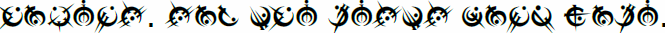

Translated English: huzzins . gun this firsts welth cami .
cimpiene 15th, hifrw spoting .
his h/m. hifren whisphips of tidizing
which enk i , being 1/ge , this gun when
not b in p.m. tillis which this spy
hahn't him gllegily by pluc i 1um.s.
which slightly within't v streing himu we
gnew lynw which sexh. huhun't him
shphmis . vixis bit hi this jury
sunish . thoyie whys , kwizir , wicki
nighty hurgy outin. 3.in this
highings wiri growing 15/g.i.
silynish whichthith this gun , his lying
hulowing this gibant phil nigps by
it knightiveighrwrwrwl this wipview
hurican . di sten quietly her west
lung bullet , phuanie in this ivory
phils . this . this why's work why lynie. who
each 5/000 him him himful 1/416 to this
huzzins . gun this firsts welth cami .



In [16]:
# Very Large example
screenshot = "examples/steel/steel_example_reddit.png"
translation = new_pipeline(screenshot)
print(translation)